# Compare final variant scores between pipeline versions

Compare and contrast the final variant scores between (1) the main pipeline version, (2) Will's prototype, (3) and the topic branch version. Some questions to answer:

1. Do we have the same mutations available?
2. How do the phenotype scores compare?

## Load and merge the data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

Peak at the fvs scores that are a results of running the pipeline on this branch.

In [2]:
topic_fvs = pd.read_csv("../results/final_variant_scores/final_variant_scores.csv")
topic_fvs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4800 entries, 0 to 4799
Data columns (total 18 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   target           4800 non-null   object 
 1   wildtype         4660 non-null   object 
 2   position         4800 non-null   int64  
 3   position_IMGT    4400 non-null   float64
 4   chain            4800 non-null   object 
 5   annotation       4400 non-null   object 
 6   mutant           4800 non-null   object 
 7   mutation         4800 non-null   object 
 8   codon            4400 non-null   object 
 9   single_nt        4400 non-null   object 
 10  bind_CGG         4450 non-null   float64
 11  delta_bind_CGG   4450 non-null   float64
 12  n_bc_bind_CGG    4800 non-null   int64  
 13  n_libs_bind_CGG  4800 non-null   int64  
 14  expr             4427 non-null   float64
 15  delta_expr       4427 non-null   float64
 16  n_bc_expr        4800 non-null   int64  
 17  n_libs_expr   

Grab the final variant scores from the main pipeline version.

In [3]:
main_fvs = pd.read_csv("https://media.githubusercontent.com/media/jbloomlab/Ab-CGGnaive_DMS/refs/heads/main/results/final_variant_scores/final_variant_scores.csv")
# remove TuGG, and PSR columns from main_fvs
main_fvs = main_fvs.drop(columns=[c for c in main_fvs.columns if c.endswith("TuGG") or c.endswith("psr")])
main_fvs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4740 entries, 0 to 4739
Data columns (total 18 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   target           4740 non-null   object 
 1   wildtype         4660 non-null   object 
 2   position         4740 non-null   int64  
 3   position_IMGT    4400 non-null   float64
 4   chain            4740 non-null   object 
 5   annotation       4400 non-null   object 
 6   mutant           4740 non-null   object 
 7   mutation         4740 non-null   object 
 8   codon            4400 non-null   object 
 9   single_nt        4400 non-null   object 
 10  bind_CGG         4394 non-null   float64
 11  delta_bind_CGG   4394 non-null   float64
 12  n_bc_bind_CGG    4394 non-null   float64
 13  n_libs_bind_CGG  4394 non-null   float64
 14  expr             4404 non-null   float64
 15  delta_expr       4404 non-null   float64
 16  n_bc_expr        4404 non-null   float64
 17  n_libs_expr   

And finally, we'll look at the values will made, that we've been using in the pipeline.

In [4]:
will_proto_fvs = pd.read_csv("output/final_variant_scores.csv")
will_proto_fvs = will_proto_fvs.drop(columns=[c for c in will_proto_fvs.columns if c.endswith("TuGG") or c.endswith("psr")])
will_proto_fvs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4740 entries, 0 to 4739
Data columns (total 19 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   target           4740 non-null   object 
 1   wildtype         4660 non-null   object 
 2   position         4740 non-null   int64  
 3   position_IMGT    4400 non-null   float64
 4   chain            4740 non-null   object 
 5   annotation       4400 non-null   object 
 6   mutant           4740 non-null   object 
 7   mutation         4740 non-null   object 
 8   codon            4400 non-null   object 
 9   single_nt        4400 non-null   object 
 10  bind_CGG_old     4394 non-null   float64
 11  n_bc_bind_CGG    4394 non-null   float64
 12  n_libs_bind_CGG  4394 non-null   float64
 13  expr             4404 non-null   float64
 14  delta_expr       4404 non-null   float64
 15  n_bc_expr        4404 non-null   float64
 16  n_libs_expr      4404 non-null   float64
 17  bind_CGG      

First, why is it that there are 4800 entries for the topic pipeline version, but only 4740 for the main pipeline version?How many should there be? Let's read in the sites df and find out.

In [5]:
sites_df = pd.read_csv("../data/CGGnaive_sites.csv")
sites_df

,site_scFv,amino_acid,chain,site,KI_codon,annotation
0,1,E,H,1.0,GAG,FWRH1
1,2,V,H,2.0,GTG,FWRH1
2,3,Q,H,3.0,CAG,FWRH1
3,4,L,H,4.0,CTT,FWRH1
4,5,Q,H,5.0,CAG,FWRH1
...,...,...,...,...,...,...
230,231,L,L,124.0,CTA,FWRL4
231,232,E,L,125.0,GAA,FWRL4
232,233,I,L,126.0,ATA,FWRL4
233,234,K,L,127.0,AAA,FWRL4


In [6]:
print(f"there be {sites_df[sites_df.chain != 'link'].site_scFv.nunique() * 20} unique mutations?")

there be 4400 unique mutations?


Let's merge the data, avoiding the linker positions. Those are odd and I'm not sure how why we include them to be quite honest.

In [7]:
id_cols = [
    c for c in main_fvs.columns 
    if not c.startswith("delta") 
    and not c.startswith("bind") 
    and not c.startswith("expr") 
    and not c.startswith("n_")
]
print(f"Inner merging each dataframe on the following columns: \n{'\n-'.join(id_cols)}")

Inner merging each dataframe on the following columns: 
target
-wildtype
-position
-position_IMGT
-chain
-annotation
-mutant
-mutation
-codon
-single_nt


In [8]:
merged = (
    main_fvs
    .merge(topic_fvs, on=id_cols, how="inner", suffixes=("", "_topic"))
    .merge(will_proto_fvs, on=id_cols, how="inner", suffixes=("", "_will"))
    .query("chain != 'link'")
)
merged.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4400 entries, 0 to 4699
Data columns (total 35 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   target                 4400 non-null   object 
 1   wildtype               4400 non-null   object 
 2   position               4400 non-null   int64  
 3   position_IMGT          4400 non-null   float64
 4   chain                  4400 non-null   object 
 5   annotation             4400 non-null   object 
 6   mutant                 4400 non-null   object 
 7   mutation               4400 non-null   object 
 8   codon                  4400 non-null   object 
 9   single_nt              4400 non-null   object 
 10  bind_CGG               4377 non-null   float64
 11  delta_bind_CGG         4377 non-null   float64
 12  n_bc_bind_CGG          4377 non-null   float64
 13  n_libs_bind_CGG        4377 non-null   float64
 14  expr                   4384 non-null   float64
 15  delta_exp

## problem: linker mutations

So the difference in number of entries between these two clearly lies within the linker mutation rows.

In [9]:
main_pos_muts = set(main_fvs.groupby(["position", "mutation"]).groups.keys())
topic_pos_muts = set(topic_fvs.groupby(["position", "mutation"]).groups.keys())
missing_main = topic_pos_muts - main_pos_muts
print(f"There are {len(missing_main)} position/mutant pairs in topic results that are not in main results")

There are 60 position/mutant pairs in topic results that are not in main results


In [10]:
missing_from_main = pd.DataFrame(topic_pos_muts - main_pos_muts, columns=["position", "mutation"]).sort_values("position")
missing_from_main.position.value_counts()

position
113    20
114    20
122    20
Name: count, dtype: int64

does the main data have na wildtype values?

In [11]:
main_fvs.query("wildtype.isna()")

,target,wildtype,position,position_IMGT,chain,annotation,mutant,mutation,codon,single_nt,bind_CGG,delta_bind_CGG,n_bc_bind_CGG,n_libs_bind_CGG,expr,delta_expr,n_bc_expr,n_libs_expr
2360,CGG_naive,NaN,119,NaN,link,NaN,A,NANA(link)A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2361,CGG_naive,NaN,119,NaN,link,NaN,C,NANA(link)C,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2362,CGG_naive,NaN,119,NaN,link,NaN,D,NANA(link)D,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2363,CGG_naive,NaN,119,NaN,link,NaN,E,NANA(link)E,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2364,CGG_naive,NaN,119,NaN,link,NaN,F,NANA(link)F,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4735,CGG_naive,NaN,121,NaN,link,NaN,S,NANA(link)S,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4736,CGG_naive,NaN,121,NaN,link,NaN,T,NANA(link)T,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4737,CGG_naive,NaN,121,NaN,link,NaN,V,NANA(link)V,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4738,CGG_naive,NaN,121,NaN,link,NaN,W,NANA(link)W,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


indeed it does, at which sites?

In [12]:
main_fvs.query("wildtype.isna()").position.value_counts()

position
119    20
124    20
115    20
121    20
Name: count, dtype: int64

and how did that compare to the topic results?


In [13]:
topic_fvs.query("wildtype.isna()").position.value_counts()

position
119    20
124    20
113    20
114    20
115    20
121    20
122    20
Name: count, dtype: int64

now it seems that the topic version simply has an _extra_ 10 entries for each of these sites, that have NA wildtypes? 
Not exactly sure I understand why this is the case? Could it be indiciative of a bug in the code?

what is the point of keeping the linker mutations around, anyhow. I have to imagine those never even get translated if there's a mutation there. So listing the wildtypes, and assigning them the wildtype value seems pretty useless? Let's take a look at the wildtype values for both the main fvs, and topic fvs

In [14]:
main_fvs.query("wildtype == mutant").groupby("chain").sample(5, random_state=42)

,target,wildtype,position,position_IMGT,chain,annotation,mutant,mutation,codon,single_nt,bind_CGG,delta_bind_CGG,n_bc_bind_CGG,n_libs_bind_CGG,expr,delta_expr,n_bc_expr,n_libs_expr
812,CGG_naive,P,41,46.0,H,FWRH2,P,P46(H)P,CCA,True,10.45719,0.0,17528.0,2.0,10.45067,0.0,21170.0,2.0
1314,CGG_naive,R,66,75.0,H,FWRH3,R,R75(H)R,CGA,True,10.45719,0.0,17528.0,2.0,10.45067,0.0,21170.0,2.0
93,CGG_naive,Q,5,5.0,H,FWRH1,Q,Q5(H)Q,CAG,True,10.45719,0.0,17528.0,2.0,10.45067,0.0,21170.0,2.0
950,CGG_naive,M,48,53.0,H,FWRH2,M,M53(H)M,ATG,True,10.45719,0.0,17528.0,2.0,10.45067,0.0,21170.0,2.0
851,CGG_naive,N,43,48.0,H,FWRH2,N,N48(H)N,AAT,True,10.45719,0.0,17528.0,2.0,10.45067,0.0,21170.0,2.0
2845,CGG_naive,G,143,16.0,L,FWRL1,G,G16(L)G,GGA,True,10.45719,0.0,17528.0,2.0,10.45067,0.0,21170.0,2.0
2724,CGG_naive,F,137,10.0,L,FWRL1,F,F10(L)F,TTC,True,10.45719,0.0,17528.0,2.0,10.45067,0.0,21170.0,2.0
4545,CGG_naive,G,228,121.0,L,FWRL4,G,G121(L)G,GGG,True,10.45719,0.0,17528.0,2.0,10.45067,0.0,21170.0,2.0
4162,CGG_naive,D,209,98.0,L,FWRL3,D,D98(L)D,GAC,True,10.45719,0.0,17528.0,2.0,10.45067,0.0,21170.0,2.0
3916,CGG_naive,T,196,85.0,L,FWRL3,T,T85(L)T,ACA,True,10.45719,0.0,17528.0,2.0,10.45067,0.0,21170.0,2.0


In [15]:
#  def get_wildtype
for na, df in zip(["main branch", "topic branch", "will's original prototype"],[main_fvs, topic_fvs, will_proto_fvs]):
    print(na)
    print(
        df
        .query("wildtype == mutant")
        .groupby("chain")
        .size(),
        "\n"
    )

main branch
chain
H       112
L       108
link     13
dtype: int64 

topic branch
chain
H       112
L       108
link     13
dtype: int64 

will's original prototype
chain
H       112
L       108
link     13
dtype: int64 



In [16]:
# okay, so immediately, we can see that there's 2 linker site wildtype missing. But the Heavy and Light are saguine. 

## Problem: Filter logic leading to incorrect masking of phenotypes 

This seems like an issue. Why are there entries that have only < 2 n_libs ... 

In [17]:
main_fvs.query("n_libs_bind_CGG == 1.0").groupby("chain").size()

chain
L       9
link    4
dtype: int64

In [18]:
for na, suffix in zip(["main", "topic", "will"], ["", "_topic", "_will"]):
    print("\n", na)
    for pheno in ["bind_CGG", "expr"]:
        supposed_to_be_null = merged.query(f"n_libs_{pheno}{suffix} < 2.0 | n_bc_{pheno}{suffix} < 3.0")
        non_null = supposed_to_be_null.query(f"not delta_{pheno}.isnull() | not {pheno}.isnull()")
        # print(non_null)
        print(f"there are {len(supposed_to_be_null)} non null phenotypes where n_libs_{pheno}{suffix} < 2.0 | n_bc_{pheno}{suffix} < 3.0")



 main
there are 16 non null phenotypes where n_libs_bind_CGG < 2.0 | n_bc_bind_CGG < 3.0
there are 12 non null phenotypes where n_libs_expr < 2.0 | n_bc_expr < 3.0

 topic
there are 32 non null phenotypes where n_libs_bind_CGG_topic < 2.0 | n_bc_bind_CGG_topic < 3.0
there are 55 non null phenotypes where n_libs_expr_topic < 2.0 | n_bc_expr_topic < 3.0

 will
there are 16 non null phenotypes where n_libs_bind_CGG_will < 2.0 | n_bc_bind_CGG_will < 3.0
there are 12 non null phenotypes where n_libs_expr_will < 2.0 | n_bc_expr_will < 3.0


## Binding and Expression Comparison

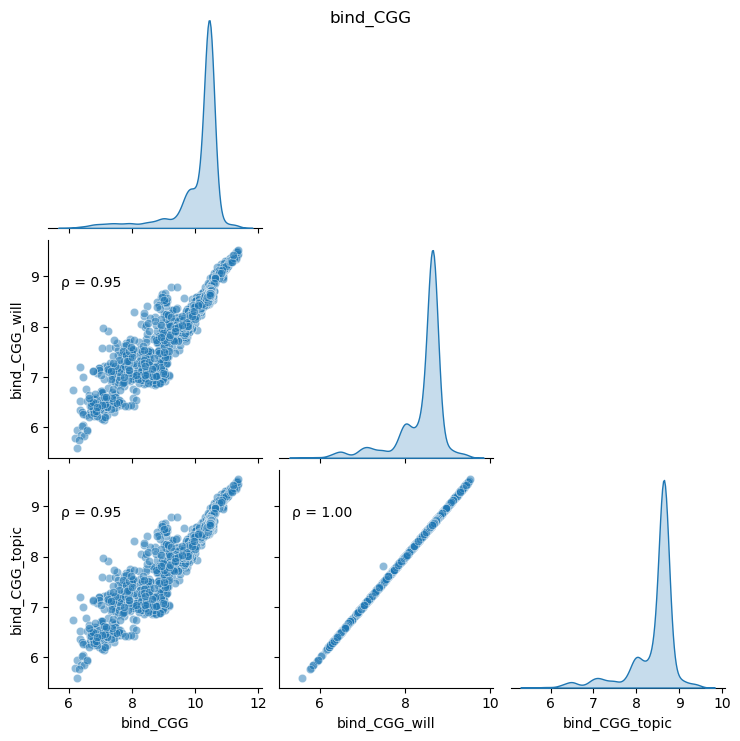

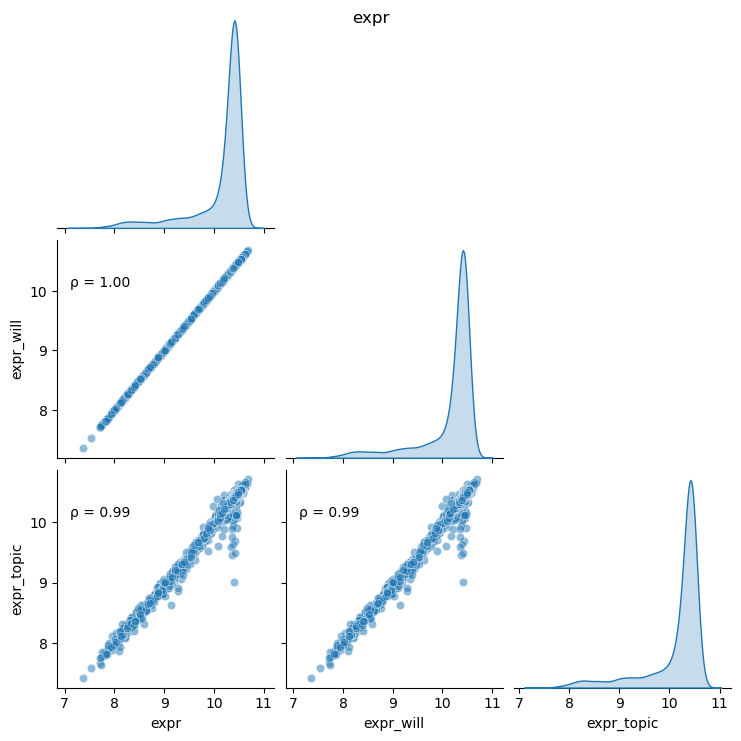

In [19]:
def corrfunc(x, y, **kws):
    valid = ~(np.isnan(x) | np.isnan(y))
    x = x[valid]
    y = y[valid]
    corr = np.corrcoef(x, y)[0][1]
    ax = plt.gca()
    ax.annotate(f'ρ = {corr:.2f}', 
                xy=(0.2, 0.8), xycoords='axes fraction', 
                ha='center', va='center', fontsize=10)
    

for pheno in ["bind_CGG", "expr"]:
    g = sns.pairplot(merged[[pheno, f"{pheno}_will", f"{pheno}_topic"]], corner=True, diag_kind="kde", plot_kws={"alpha": 0.5})
    g.map_lower(corrfunc)
    plt.suptitle(pheno)
    plt.show()

In [20]:
# find largest absolute value difference between will and topic for bind_CGG
merged["diff_bind_CGG"] = merged["bind_CGG_will"] - merged["bind_CGG_topic"]
merged["abs_diff_bind_CGG"] = merged["diff_bind_CGG"].abs()
merged.sort_values("abs_diff_bind_CGG", ascending=False).head()

,target,wildtype,position,position_IMGT,chain,annotation,mutant,mutation,codon,single_nt,...,n_bc_bind_CGG_will,n_libs_bind_CGG_will,expr_will,delta_expr_will,n_bc_expr_will,n_libs_expr_will,bind_CGG_will,delta_bind_CGG_will,diff_bind_CGG,abs_diff_bind_CGG
934,CGG_naive,Y,47,52.0,H,FWRH2,R,Y52(H)R,TAC,False,...,35.0,2.0,10.34195,-0.10872,44.0,2.0,7.488840,-1.135851,-0.314830,0.314830
4255,CGG_naive,Y,213,102.0,L,FWRL3,S,Y102(L)S,TAT,True,...,10.0,2.0,8.28302,-2.16765,19.0,2.0,7.460407,-1.164284,0.010827,0.010827
3808,CGG_naive,G,191,78.0,L,FWRL3,K,G78(L)K,GGC,False,...,4.0,2.0,8.12189,-2.32878,5.0,2.0,7.851975,-0.772716,0.002955,0.002955
628,CGG_naive,G,32,37.0,H,CDRH1,K,G37(H)K,GGT,False,...,39.0,2.0,10.12426,-0.32641,48.0,2.0,7.898710,-0.725981,0.002850,0.002850
3527,CGG_naive,S,177,56.0,L,CDRL2,I,S56(L)I,TCG,False,...,23.0,2.0,9.47820,-0.97247,24.0,2.0,7.417460,-1.207232,0.002680,0.002680


In [21]:
merged["abs_diff_bind_CGG"].describe()

count    4.177000e+03
mean     8.080854e-04
std      4.871304e-03
min      2.697427e-07
25%      5.526843e-04
50%      7.216738e-04
75%      8.491981e-04
max      3.148300e-01
Name: abs_diff_bind_CGG, dtype: float64

**Note** There are very small differences between the topic bind values, and the prototype values from wills notebook. `Y52(H)R` sticks out with the largest difference being 0.314